# Ch16 工具变量法

## 内容摘要

到目前为止，本书中描述的因果推论方法都基于一个不可检验的关键假设：all variables needed to adjust for confounding and selection bias have been identified and correctly measured. 如果这个假设是错误的，并且在一定程度上一直是这样，那么我们的因果估计中就会有剩余偏差。

It turns out that there exist other methods  Instrumental variable estimation is one of those methods. Economists and other social scientists reading this book can breathe now. We are finally going to describe a very common method in their fields, a method that is unlike any other we have discussed so far.

事实证明，存在其他方法可以that can validly estimate causal effects under an alternative set of assumptions that do not require measuring all adjustment factors. 工具变量估计是这些方法之一。读这本书的经济学家和其他社会科学家 can breathe now. 我们最终将在他们的领域中描述一种非常通用的方法，该方法与我们迄今为止讨论的任何其他方法都不相同。

### 16.1 模型假设

The three intrumental conditions.

`
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)
`

In [18]:
from dowhy import CausalModel
import dowhy.datasets

# Load some sample data
data = dowhy.datasets.linear_dataset(
    beta=10,
    num_common_causes=5,
    num_instruments=2,
    num_samples=1000,
    treatment_is_binary=True)

# Create a causal model from the data and given graph.
model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    graph=data["gml_graph"])

# Identify causal effect and return target estimands
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['Unobserved Confounders', 'W3', 'W0', 'W2', 'W1', 'W4']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z0', 'Z1']


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W3,W0,W2,W1,W4))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W2,W1,W4,U) = P(y|v0,W3,W0,W2,W1,W4)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)



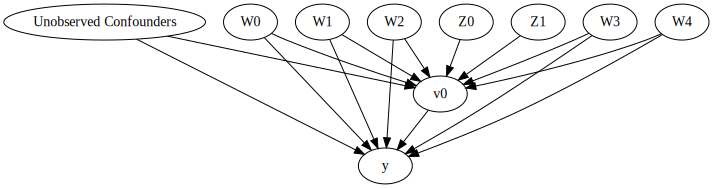

In [26]:
from graphviz import Source
Source(data['dot_graph'])

### 16.2 The usal IV estimand

The usual IV estimand for a dichotomous instrument. 


$$
\frac{E[Y|Z=1] - E[Y|Z=0]}{E[A|Z=1] - E[A|Z=0]}
$$

在我们的例子中：

`Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))`


### 16.3  A fourth identifying condition: homogeneity

上述的三个条件 (i)-(iii) 并不能保证 that the IV estimand is the average causal effect of treatment $A$ on $Y$. A fourth condition, effect homogeneity (iv), is needed. 在这里，我们按照历史出现的顺序阐述 four possible homogeneity conditions (iv).

- The most extreme, and oldest, version of homogeneity condition (iv) is constant effect of treatment $A$ on outcome $Y$ across individuals.
- A second, less extreme homogeneity condition (iv) for dichotomous $Z$ and $A$ is equality of the average causal effect of $A$ on $Y$ across levels of $Z$ in both the treated and in the untreated.
- Additive structural mean models and IV estimation. This third homogeneity condition (iv) is often implausible because some unmeasured confounders may also be effect modifiers. 
- Another type of homogeneity condition (iv) is that the $Z-A$ association on the additive scale is constant across levels of the confounders $U$.

### 16.4 An alternative fourth condition: monotonicity

### 16.5 The three instrumental conditions revisited

前面的部分讨论了相对优缺点 of choosing monotonicity or homogeneity as the condition (iv). Our discussion implicitly assumed that the proposed instrument $Z$ was in fact an instrument.

### 16.6 Instrumental variable estimation versus other methods

IV估计在至少三个方面与所有先前讨论的方法不同:

- First, IV estimation requires modeling assumptions even if infinite data were available.
- Second, relatively minor violations of conditions (i)-(iv) for IV estimation may result in large biases of unpredictable or counterintuitive direction.
- Third, the ideal setting for the applicability of standard IV estimation is more restrictive than that for other methods.


## Programs

In [2]:
## Setup and imports
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.optimize
%matplotlib inline

In [3]:
nhefs_all = pd.read_excel('NHEFS.xls')

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


Create the instrument, $Z$

In [5]:
nhefs_all['highprice'] = (nhefs_all.price82 >= 1.5).astype('int')

We'll use a different subset of the data than used previously

In [6]:
restriction_cols = ['wt82', 'education', 'price82']
missing = nhefs_all[restriction_cols].isnull().any(axis=1)
nhefs = nhefs_all.loc[~missing]

In [7]:
nhefs.shape

(1476, 65)

We'll check whether $Z$ (`highprice`) and $A$ (`qsmk`) are associated, that $\Pr[A=1|Z=1] - \Pr[A=1|Z=0] \not = 0$

In [8]:
a_given_z1 = nhefs.qsmk.loc[nhefs.highprice == 1]
a_given_z0 = nhefs.qsmk.loc[nhefs.highprice == 0]

pr_a1_z1 = (a_given_z1 == 1).sum() * 1.0 / a_given_z1.shape[0]
pr_a1_z0 = (a_given_z0 == 1).sum() * 1.0 / a_given_z0.shape[0]

print("              Pr[A=1|Z=1] = {:>4.1f}%".format(pr_a1_z1 * 100))
print("              Pr[A=1|Z=0] = {:>4.1f}%".format(pr_a1_z0 * 100))
print("Pr[A=1|Z=1] − Pr[A=1|Z=0] = {:>4.1f}%".format((pr_a1_z1 - pr_a1_z0) * 100))

              Pr[A=1|Z=1] = 25.8%
              Pr[A=1|Z=0] = 19.5%
Pr[A=1|Z=1] − Pr[A=1|Z=0] =  6.3%


### Program 16.1

Pg 196: For a dichotomous instrument $Z$ that also meets condition (iv) from section 16.3,

$$
    \text{E}[Y^{a=1}] - \text{E}[Y^{a=0}] = \frac{\text{E}[Y|Z=1] - \text{E}[Y|Z=0]}{\text{E}[A|Z=1] - \text{E}[A|Z=0]}
$$

"We estimated the numerator and denominator of the IV estimand by simply calculating the four sample averages ...", pg 197

In [9]:
est_y_given_z1 = nhefs.wt82_71[nhefs.highprice == 1].mean()
est_y_given_z0 = nhefs.wt82_71[nhefs.highprice == 0].mean()
est_a_given_z1 = nhefs.qsmk[nhefs.highprice == 1].mean()
est_a_given_z0 = nhefs.qsmk[nhefs.highprice == 0].mean()

In [10]:
print('estimated E[Y|Z=1] = {:>0.3f}'.format(est_y_given_z1))
print('estimated E[Y|Z=0] = {:>0.3f}'.format(est_y_given_z0))
print('estimated E[A|Z=1] = {:>0.3f}'.format(est_a_given_z1))
print('estimated E[A|Z=0] = {:>0.3f}'.format(est_a_given_z0))

estimated E[Y|Z=1] = 2.686
estimated E[Y|Z=0] = 2.536
estimated E[A|Z=1] = 0.258
estimated E[A|Z=0] = 0.195


In [11]:
estimate = (est_y_given_z1 - est_y_given_z0) / (est_a_given_z1 - est_a_given_z0)
print('the usual IV estimate: {:>0.2f}kg'.format(estimate))

the usual IV estimate: 2.40kg


"Equivalently, we could have fit two (saturated) linear models to estimate the differences in the denominator and the numerator..."

In [12]:
model = sm.OLS.from_formula('wt82_71 ~ highprice', data=nhefs)
numer = model.fit()

model = sm.OLS.from_formula('qsmk ~ highprice', data=nhefs)
denom = model.fit()

In [13]:
estimate = numer.params['highprice'] / denom.params['highprice']
print('the usual IV estimate: {:>0.2f}kg'.format(estimate))

the usual IV estimate: 2.40kg


### Program 16.2

Two stage least squares estimator

First, we'll manually use two models, but this will give the wrong confidence interval

In [14]:
model = sm.OLS.from_formula('qsmk ~ highprice', data=nhefs)
stg_1 = model.fit()

nhefs['A_pred'] = stg_1.predict(nhefs)

model = sm.OLS.from_formula('wt82_71 ~ A_pred', data=nhefs)
stg_2 = model.fit()

In [15]:
stg_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.0682,5.140,0.402,0.687,-8.014,12.151
A_pred,2.3963,20.055,0.119,0.905,-36.942,41.735


In [16]:
estimate = stg_2.params['A_pred']
print('the 2-stage estimate: {:>0.2f}kg'.format(estimate))

the 2-stage estimate: 2.40kg


"A commonly used rule of thumb is to declare an instrument as weak if the F-statistic from the first-stage model is less than 10"

In [17]:
print('1st-stage F-statistic: {:>0.2f}'.format(stg_1.fvalue))

1st-stage F-statistic: 0.82


The confidence intervals in the second-stage model aren't quite right

We'll do the two-stage model again, using `IV2SLS` from the `linearmodels` package

In [18]:
from linearmodels.iv import IV2SLS as lm_IV2SLS

In [19]:
model = lm_IV2SLS.from_formula(
    'wt82_71 ~ 1 + [qsmk ~ highprice]',
    data=nhefs
)

two_stage = model.fit(cov_type='homoskedastic')

In [20]:
two_stage.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,2.0682,5.0817,0.4070,0.6840,-7.8917,12.028
qsmk,2.3963,19.827,0.1209,0.9038,-36.463,41.256


In [21]:
# `conf_ints` is slightly different between linearmodels and statsmodels

est = two_stage.params.qsmk
conf_ints = two_stage.conf_int(level=0.95)
lo, hi = conf_ints['lower']['qsmk'], conf_ints['upper']['qsmk']

print('         estimate   95% C.I.')
print('beta_1    {:>6.2f}   ({:>0.1f}, {:>0.1f})'.format(est, lo, hi))

         estimate   95% C.I.
beta_1      2.40   (-36.5, 41.3)


### Program 16.3

"The parameters of structural mean models can be estimated via g-estimation"

We'll solve this using the same methods as in Program 14.2. Recall, in that program we searched for a $\psi^\dagger$ that would minimize the coefficient on $H(\psi^\dagger)$. The $\psi^\dagger$ that achieves the minimum is our estimate of the causal effect.

In Program 14.2 we ended with a call to `scipy.optimize.minimize` to do the fine-grained search for $\psi^\dagger$. Here, we'll just go straight to that.

In [22]:
def logit_abs_alpha(psi):
    nhefs['H_of_psi'] = nhefs.wt82_71 - psi * nhefs.qsmk
    gee = sm.GEE.from_formula(
        'highprice ~ H_of_psi',
        data=nhefs,
        groups=nhefs.seqn,
        family=sm.families.Binomial()
    )
    res = gee.fit()
    alpha = res.params.H_of_psi
    return abs(alpha)

This can take a while to run

In [23]:
opt_results = scipy.optimize.minimize(
    fun=logit_abs_alpha,
    x0=4.0,
    tol=1e-4
)

opt_results

      fun: 2.9857141760250987e-12
 hess_inv: array([[4213.9017246]])
      jac: array([0.00061682])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 312
      nit: 1
     njev: 100
   status: 2
  success: False
        x: array([2.3962701])

In [24]:
print('best estimate: {:>0.3f}'.format(opt_results.x[0]))

best estimate: 2.396


### Program 16.4

We'll calculate the IV estimate using a few different cutoffs for `highprice`

First, we'll calculate the "usual" IV estimate using data means

In [25]:
def wald_estimate(Y, A, Z):
    numer = Y.loc[Z == 1].mean() - Y.loc[Z == 0].mean()
    denom = A.loc[Z == 1].mean() - A.loc[Z == 0].mean()
    return numer / denom

In [26]:
for cutoff in (1.6, 1.7, 1.8, 1.9):
    estimate = wald_estimate(
        nhefs.wt82_71,
        nhefs.qsmk,
        (nhefs.price82 >= cutoff).astype('int')
    )
    print('cutoff price: ${:>0.2f}   estimate: {:>6.2f}kg'.format(cutoff, estimate))

cutoff price: $1.60   estimate:  41.28kg
cutoff price: $1.70   estimate: -40.91kg
cutoff price: $1.80   estimate: -21.10kg
cutoff price: $1.90   estimate: -12.81kg


Next we'll re-calculate using 2-stage models, to get confidence intervals

In [27]:
print('         estimate       95% C.I.')
for cutoff in (1.6, 1.7, 1.8, 1.9):
    nhefs['highprice'] = (nhefs.price82 >= cutoff).astype('int')
    
    model = lm_IV2SLS.from_formula(
        'wt82_71 ~ 1 + [qsmk ~ highprice]',
        data=nhefs
    )
    res = model.fit(cov_type='homoskedastic')
    
    est = res.params.qsmk
    conf_ints = res.conf_int(level=0.95)
    lo, hi = conf_ints['lower']['qsmk'], conf_ints['upper']['qsmk']

    print('${:>0.2f}     {:>6.2f}   ({:>6.1f}, {:>6.1f})'.format(cutoff, est, lo, hi))

    
# restore `highprice` to its original meaning
nhefs['highprice'] = (nhefs.price82 >= 1.50).astype('int')

         estimate       95% C.I.
$1.60      41.28   (-281.8,  364.4)
$1.70     -40.91   (-408.6,  326.8)
$1.80     -21.10   ( -76.8,   34.6)
$1.90     -12.81   ( -59.2,   33.5)


### Program 16.5

In [28]:
model = lm_IV2SLS.from_formula(
    'wt82_71 ~ 1 + sex + race + age + smokeintensity + smokeyrs' 
    '        + C(exercise) + C(active) + wt71 + [qsmk ~ highprice]',
    data=nhefs
)
res = model.fit(cov_type='homoskedastic')

In [29]:
res.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,17.280,2.3259,7.4296,0.0000,12.722,21.839
C(exercise)[T.1],0.4987,2.1624,0.2306,0.8176,-3.7395,4.7370
C(exercise)[T.2],0.5818,2.1743,0.2676,0.7890,-3.6796,4.8433
C(active)[T.1],-1.1701,0.6050,-1.9341,0.0531,-2.3559,0.0156
C(active)[T.2],-0.5123,1.3031,-0.3931,0.6942,-3.0664,2.0418
sex,-1.6444,2.6201,-0.6276,0.5303,-6.7797,3.4909
race,-0.1833,4.6314,-0.0396,0.9684,-9.2607,8.8942
age,-0.1636,0.2396,-0.6831,0.4946,-0.6332,0.3059
smokeintensity,0.0058,0.1449,0.0398,0.9683,-0.2783,0.2898
smokeyrs,0.0258,0.1608,0.1607,0.8723,-0.2893,0.3409
